# Advanced Statistical Methods Project
## Approximate derivative via piecewise linear basis using unbiased risk estimation

In [1]:
import numpy as np

from IPython import display as dp
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit

dp.set_matplotlib_formats('retina')
sns.set_style('whitegrid')
sns.despine()

%matplotlib notebook

## Step 0. Preliminaries

In [2]:
def fourier_basis_function(i, x):
    if i == 0:
        return 1
    elif i % 2 == 0:
        return np.cos(2 * np.pi * (i // 2) * x)
    else:
        return np.sin(2 * np.pi * (i // 2) * x)
    
def fourier_basis_function_prime(i, x):
    if i == 0:
        return 0
    elif i % 2 == 0:
        return - (i // 2) * np.sin(2 * np.pi * (i // 2) * x)
    else:
        return (i // 2) * np.cos(2 * np.pi * (i // 2) * x)

In [3]:
n = 200
xx = np.linspace(0, 1, 200)
X = np.arange(1, n+1) / n
M = np.arange(1, 100)

## Step 1. True function

In [4]:
np.random.seed(123)
coefs = np.random.randn(10)
coefs = np.hstack([coefs, np.array([np.random.randn() / (j - 10) ** 2 for j in range(11, n+1)])])

In [5]:
f_star = lambda x: np.sum([c * fourier_basis_function(k, x) for c, k in zip(coefs, range(n))], axis=0)
f_prime_star = lambda x: 2 * np.pi * np.sum([c * fourier_basis_function_prime(k, x) \
                                             for c, k in zip(coefs, range(n))], axis=0)

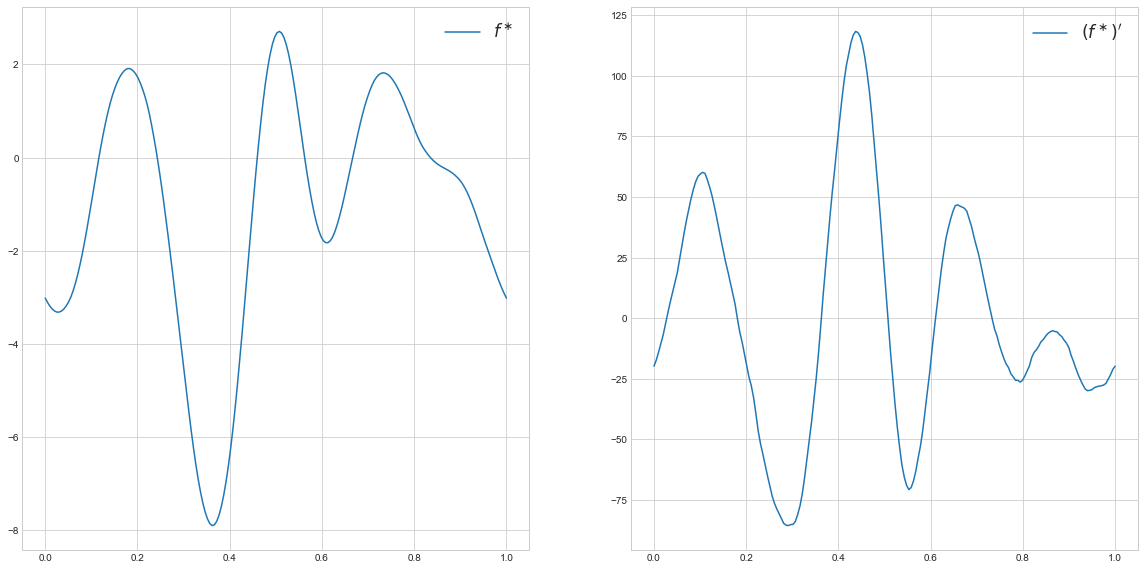

In [6]:
yy = f_star(xx)
zz = f_prime_star(xx)
fig, ax = plt.subplots(1, 2, figsize=(20,10));
ax[0].plot(xx, yy, label='$f^\\ast$');
ax[1].plot(xx, zz, label="$(f^\\ast)'$");
ax[0].legend(fontsize='xx-large');
ax[1].legend(fontsize='xx-large');

## Step 2. Covariances
### Inhomogeneous noise

In [7]:
np.random.seed(123)
inhom_variances = np.random.multivariate_normal(mean=2*np.ones(n), cov=0.4*np.eye(n))
inhom_variances = inhom_variances ** 2
inhom_variances *= 0.8 ** 2
inhom_variances = sorted(inhom_variances)

In [8]:
np.random.seed(123)
Y_inhom = f_star(X) + np.random.multivariate_normal(mean=np.zeros(n), cov=np.diag(inhom_variances))

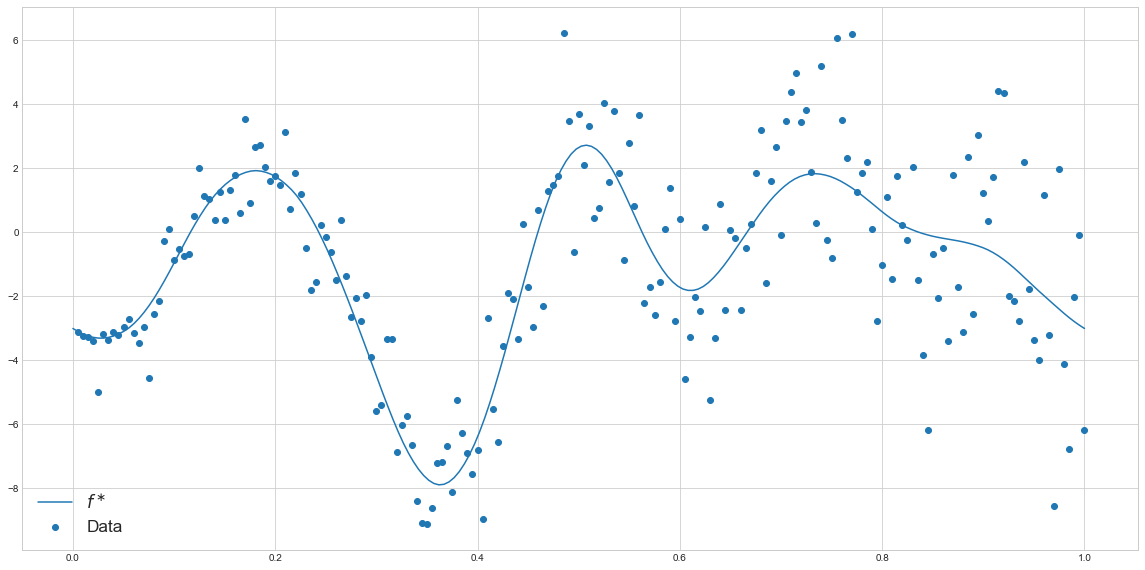

In [9]:
plt.figure(figsize=(20,10));
plt.plot(xx, yy, label='$f^\\ast$');
plt.scatter(X, Y_inhom, label='Data');
plt.legend(fontsize='xx-large', loc='lower left');

### Homogeneous noise

In [10]:
np.random.seed(123)
hom_variance = np.random.normal(loc=2, scale=0.4)
hom_variance = hom_variance ** 2
hom_variance *= 0.8 ** 2

In [11]:
np.random.seed(123)
Y_hom = f_star(X) + np.random.multivariate_normal(mean=np.zeros(n), cov=hom_variance*np.eye(n))

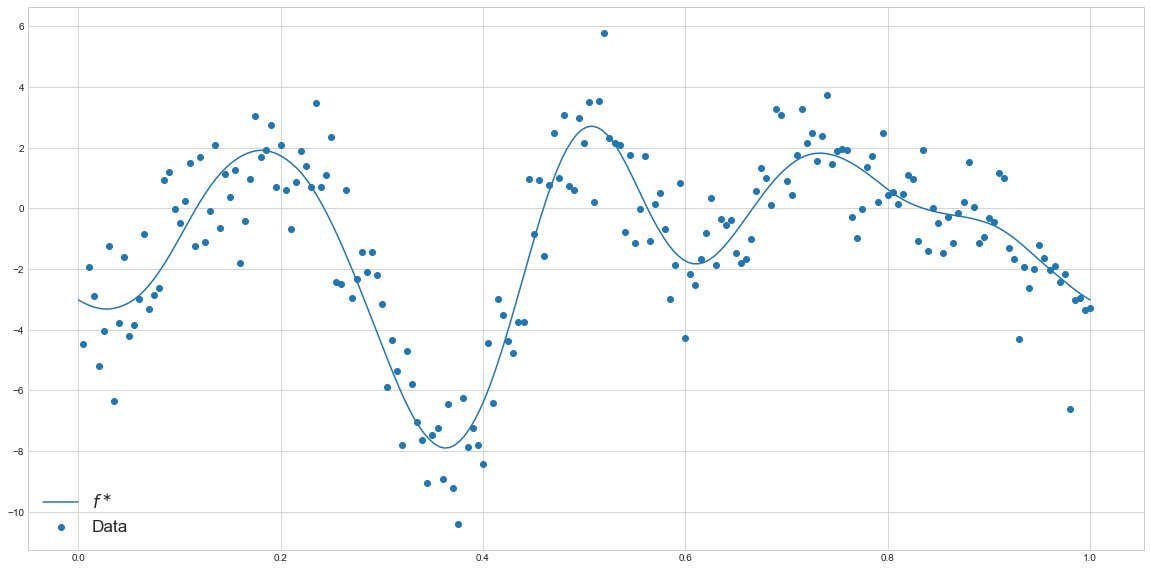

In [12]:
plt.figure(figsize=(20,10));
plt.plot(xx, yy, label='$f^\\ast$');
plt.scatter(X, Y_hom, label='Data');
plt.legend(fontsize='xx-large', loc='lower left');

### Unspecified noise

In [13]:
unsp_hom_variance = hom_variance
unsp_inhom_variance = np.mean(inhom_variances)

## Step 2.5. Matrices

Denote model $m$ (with $m$ linear pieces). Then consider $\theta \in \mathbb{R}^{2m}$, where $\theta_{2j}$ are slopes and $\theta_{2j+1}$ are intercepts. Then we can write decomposition $f = \Psi^\top \theta$, from which follows that $\Psi \in \mathbb{R}^{2m \times n}$ is block structured matrix

$$
    \Psi = \left( \begin{array}{cccccccccc}
        x_1 & \ldots & x_{b_1} & 0 & \ldots & 0 & \ldots & 0 & \ldots & 0 \\
        1 & \ldots & 1 & 0 & \ldots & 0 & \ldots & 0 & \ldots & 0 \\
        0 & \ldots & 0 & x_{b_1} & \ldots & x_{b_2} & \ldots & 0 & \ldots & 0 \\
        0 & \ldots & 0 & 1 & \ldots & 1 & \ldots & 0 & \ldots & 0 \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
        0 & \ldots & 0 & 0 & \ldots & 0 & \ldots & x_{b_{m-1}} & \ldots & x_n \\
        0 & \ldots & 0 & 0 & \ldots & 0 & \ldots & 1 & \ldots & 1
    \end{array} \right)
$$

where $x_{b_i}$ are points closest to breakpoints $x_i = \tfrac i m$.

Given that, we can compute matrix $\mathcal{S} = (\Psi \Sigma^{-1} \Psi^\top)^{-1} \Psi \Sigma^{-1}$. For both cases of noise $\Sigma$ is diagonal, thus cancels and we obtain $\mathcal{S} = (\Psi \Psi^\top)^{-1} \Psi$.

Note that objective is also a linear functional of $\theta$. Therefore estimation $\tilde{f'} = W \tilde{\theta} = W \mathcal{S} Y = \mathcal{K} Y$. Here, $W \in \mathbb{R}^{n \times 2m}$ is extracting slopes, i.e. $\theta_{2j}$

$$
    W = \left( \begin{array}{cccccc}
        1 & 0 & 0 & \ldots & 0 & 0 \\
        0 & 0 & 1 & \ldots & 0 & 0 \\
        \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
        0 & 0 & 0 & \ldots & 1 & 0
    \end{array} \right)
$$

Then, $\mathcal{K} = W \mathcal{S} = W (\Psi \Psi^\top)^{-1} \Psi$.

## Step 3. Oracle parameter choice and oracle risk

Consider loss $\rho(\tilde{f'}) = \|\tilde{f'} - (f^\ast)'\|^2 = \|W\tilde{\theta} - (f^\ast)'\|^2 = \|W \mathcal{S} Y - (f^\ast)'\|^2 = \|\mathcal{K}Y - (f^\ast)'\|^2$.

Now consider risk

$$
    \mathcal{R}(\tilde{f'}) = \mathbb{E}[\rho(\tilde{f'})] = \mathbb{E}[\|\mathcal{K}Y - (f^\ast)'\|^2] = \mathbb{E}[\|\mathcal{K}(f^\ast + \varepsilon) - (f^\ast)'\|^2] = \|\mathcal{K}f^\ast - (f^\ast)'\|^2 + \mathbb{E}[\|\mathcal{K} \varepsilon\|^2] = \|\mathcal{K}f^\ast - (f^\ast)'\|^2 + \rm{tr} \{\mathcal{K} \Sigma \mathcal{K}^\top\}
$$

In [14]:
def get_psi(m):
    psi = np.zeros((2 * m, n))
    breaks = np.arange(m+1)/m
    for k in range(m):
        idx = np.where(np.logical_and(X > breaks[k], X <= breaks[k+1]))[0]
        psi[2 * k, idx] = X[idx]
        psi[2 * k + 1, idx] = np.ones_like(idx)
    return psi

def get_w(m):
    w = np.zeros((n, 2 * m))
    breaks = np.arange(m+1)/m
    for k in range(m):
        idx = np.where(np.logical_and(X > breaks[k], X <= breaks[k+1]))[0]
        w[idx, 2*k] = 1
    return w

### Inhomogeneous noise

In [15]:
risks_inhom = np.zeros_like(M, dtype=np.float32)
losses_inhom = np.zeros_like(M, dtype=np.float32)
for i, m in enumerate(M):
    psi = get_psi(m)
    s = np.linalg.pinv(psi @ psi.T) @ psi
    w = get_w(m)
    k = w @ s
    loss = np.linalg.norm(k @ Y_inhom - f_prime_star(X), ord=2) ** 2
    risk = np.linalg.norm(k @ f_star(X) - f_prime_star(X), ord=2) ** 2 + np.trace(k @ np.diag(inhom_variances) @ k.T)
    risks_inhom[i] = risk
    losses_inhom[i] = loss

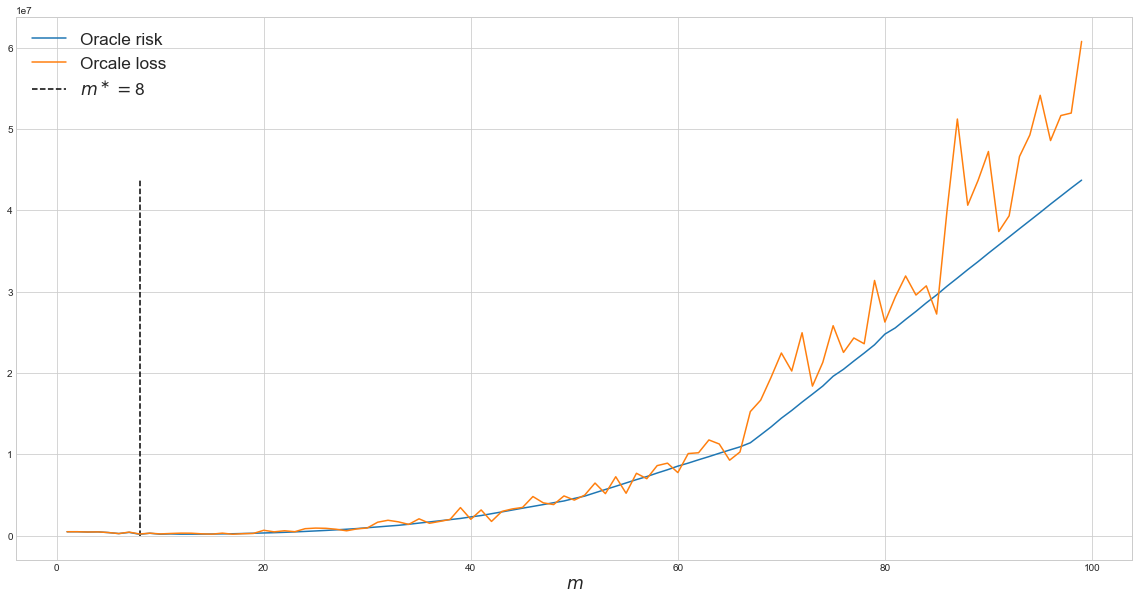

In [16]:
plt.figure(figsize=(20,10));
plt.plot(M, risks_inhom, label='Oracle risk');
plt.plot(M, losses_inhom, label='Orcale loss');
plt.vlines(np.argmin(risks_inhom)+1, 0, np.max(risks_inhom), linestyles='dashed',
           label='$m^\\ast = $%d' % (np.argmin(risks_inhom)+1))
plt.legend(fontsize='xx-large');
plt.xlabel('$m$', fontsize='xx-large');

### Homogeneous noise

In [17]:
risks_hom = np.zeros_like(M, dtype=np.float32)
losses_hom = np.zeros_like(M, dtype=np.float32)
for i, m in enumerate(M):
    psi = get_psi(m)
    s = np.linalg.pinv(psi @ psi.T) @ psi
    w = get_w(m)
    k = w @ s
    loss = np.linalg.norm(k @ Y_hom - f_prime_star(X), ord=2) ** 2
    risk = np.linalg.norm(k @ f_star(X) - f_prime_star(X), ord=2) ** 2 + np.trace(hom_variance * k @ k.T)
    risks_hom[i] = risk
    losses_hom[i] = loss

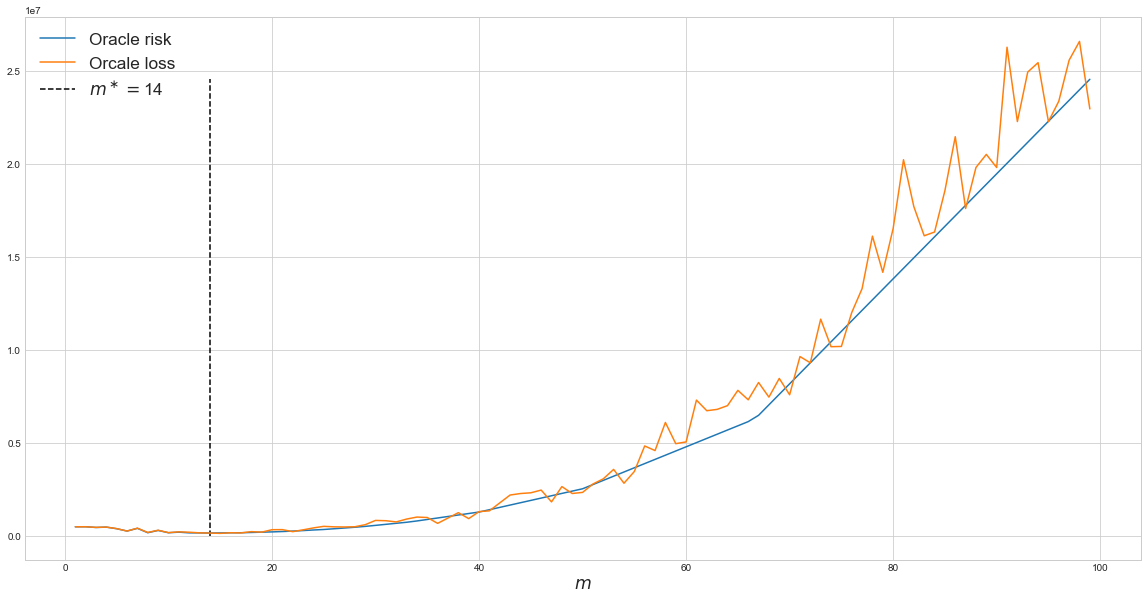

In [18]:
plt.figure(figsize=(20,10));
plt.plot(M, risks_hom, label='Oracle risk');
plt.plot(M, losses_hom, label='Orcale loss');
plt.vlines(np.argmin(risks_hom)+1, 0, np.max(risks_hom), linestyles='dashed',
           label='$m^\\ast = $%d' % (np.argmin(risks_hom)+1));
plt.legend(fontsize='xx-large');
plt.xlabel('$m$', fontsize='xx-large');

## Step 4. Unbiased risk estimation

In [19]:
m_largest = 100
psi_largest = get_psi(m_largest)
s_largest = np.linalg.pinv(psi_largest @ psi_largest.T) @ psi_largest
w_largest = get_w(m_largest)
k_largest = w_largest @ s_largest

### Inhomogeneous noise

In [20]:
risks_inhom_unb = np.zeros_like(M, dtype=np.float32)
for i, m in enumerate(M):
    psi = get_psi(m)
    s = np.linalg.pinv(psi @ psi.T) @ psi
    w = get_w(m)
    k = w @ s
    k_diff = k_largest - k
    phi_largest = k_largest @ Y_inhom
    phi = k @ Y_inhom
    p = np.trace(unsp_inhom_variance * k @ k.T)
    p_diff = np.trace(unsp_inhom_variance * k_diff @ k_diff.T)
    risk = np.linalg.norm(phi_largest - phi, ord=2) ** 2 + p - p_diff
    risks_inhom_unb[i] = risk

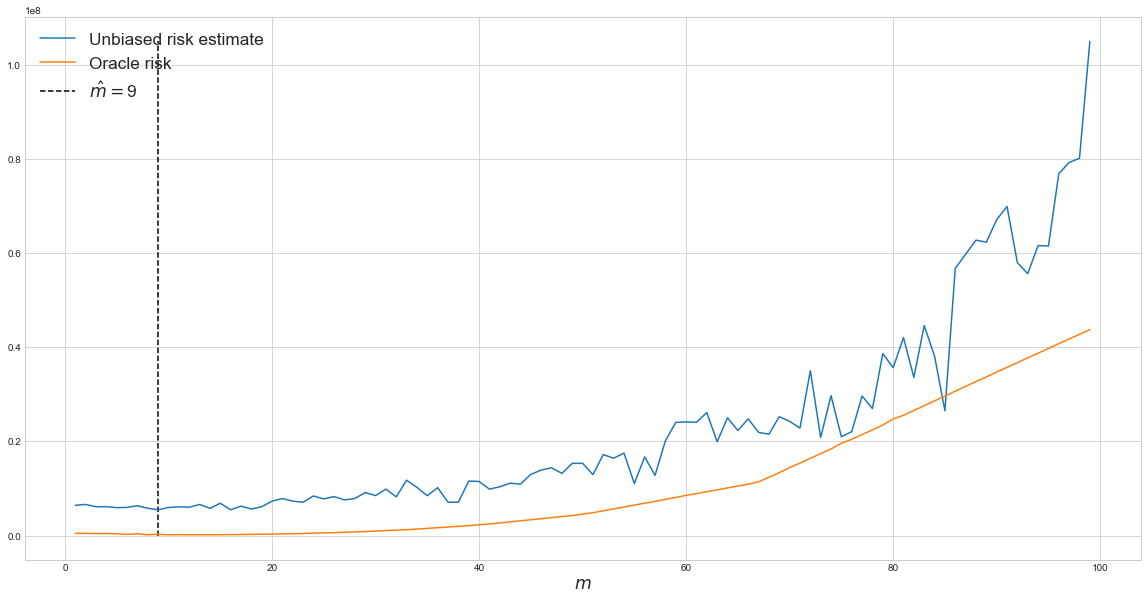

In [21]:
plt.figure(figsize=(20,10));
plt.plot(M, risks_inhom_unb, label='Unbiased risk estimate');
plt.plot(M, risks_inhom, label='Oracle risk');
plt.vlines(np.argmin(risks_inhom_unb)+1, 0, np.max(risks_inhom_unb), linestyles='dashed', 
           label='$\hat{m} = $%d' % (np.argmin(risks_inhom_unb)+1));
plt.legend(fontsize='xx-large');
plt.xlabel('$m$', fontsize='xx-large');

### Homogeneous noise

In [22]:
risks_hom_unb = np.zeros_like(M, dtype=np.float32)
for i, m in enumerate(M):
    psi = get_psi(m)
    s = np.linalg.pinv(psi @ psi.T) @ psi
    w = get_w(m)
    k = w @ s
    k_diff = k_largest - k
    phi_largest = k_largest @ Y_hom
    phi = k @ Y_hom
    p = np.trace(unsp_hom_variance * k @ k.T)
    p_diff = np.trace(unsp_hom_variance * k_diff @ k_diff.T)
    risk = np.linalg.norm(phi_largest - phi, ord=2) ** 2 + p - p_diff
    risks_hom_unb[i] = risk

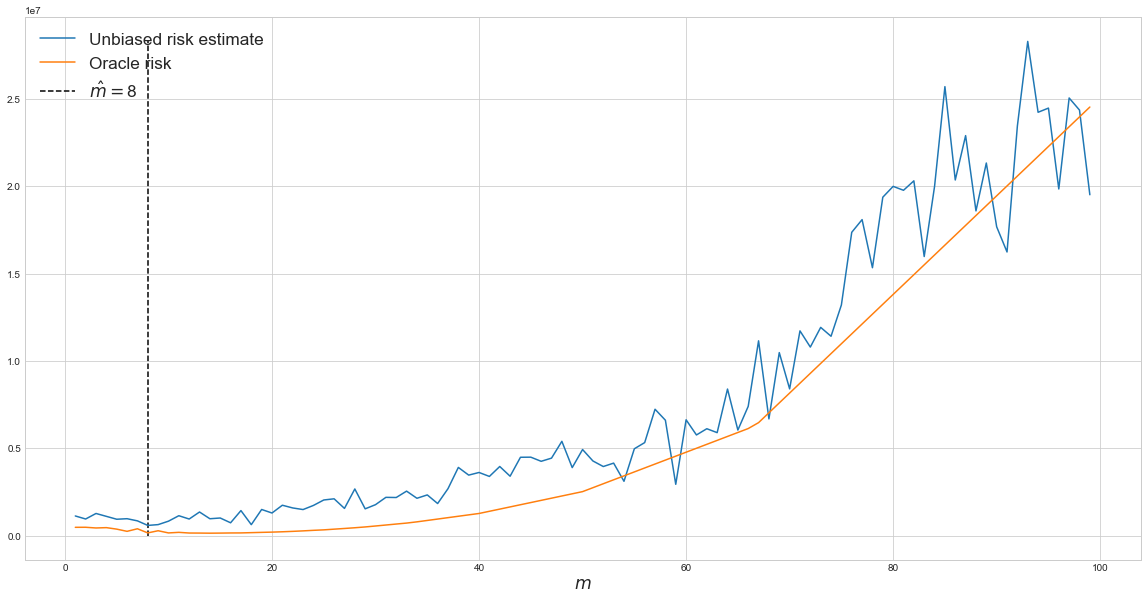

In [23]:
plt.figure(figsize=(20,10));
plt.plot(M, risks_hom_unb, label='Unbiased risk estimate');
plt.plot(M, risks_hom, label='Oracle risk');
plt.vlines(np.argmin(risks_hom_unb)+1, 0, np.max(risks_hom_unb), linestyles='dashed', 
           label='$\\hat{m} = $%d' % (np.argmin(risks_hom_unb)+1));
plt.legend(fontsize='xx-large');
plt.xlabel('$m$', fontsize='xx-large');

## Step 5. Visualization

### Inhomogeneous noise

In [24]:
m = 87
psi = get_psi(m)
s = np.linalg.pinv(psi @ psi.T) @ psi
w = get_w(m)
k = w @ s
est_oracle = k @ Y_inhom
m = 94
psi = get_psi(m)
s = np.linalg.pinv(psi @ psi.T) @ psi
w = get_w(m)
k = w @ s
est_unb = k @ Y_inhom

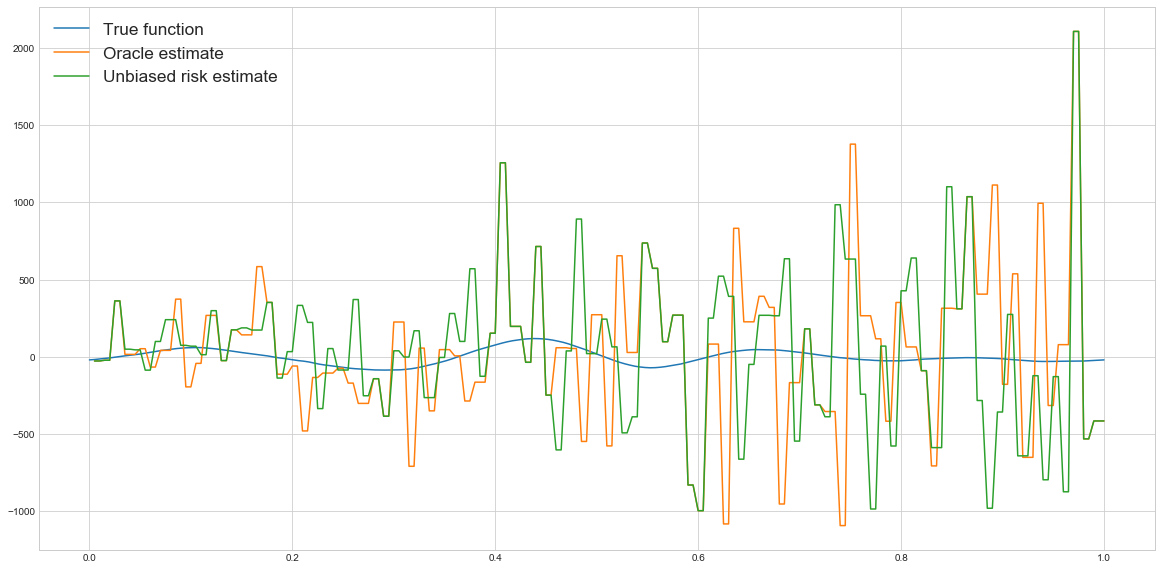

In [25]:
plt.figure(figsize=(20,10));
plt.plot(xx, f_prime_star(xx), label='True function');
plt.plot(X, est_oracle, label='Oracle estimate');
plt.plot(X, est_unb, label='Unbiased risk estimate');
plt.legend(fontsize='xx-large');

### Homogeneous noise

In [26]:
m = 99
psi = get_psi(m)
s = np.linalg.pinv(psi @ psi.T) @ psi
w = get_w(m)
k = w @ s
est_oracle = k @ Y_hom
m = 94
psi = get_psi(m)
s = np.linalg.pinv(psi @ psi.T) @ psi
w = get_w(m)
k = w @ s
est_unb = k @ Y_hom

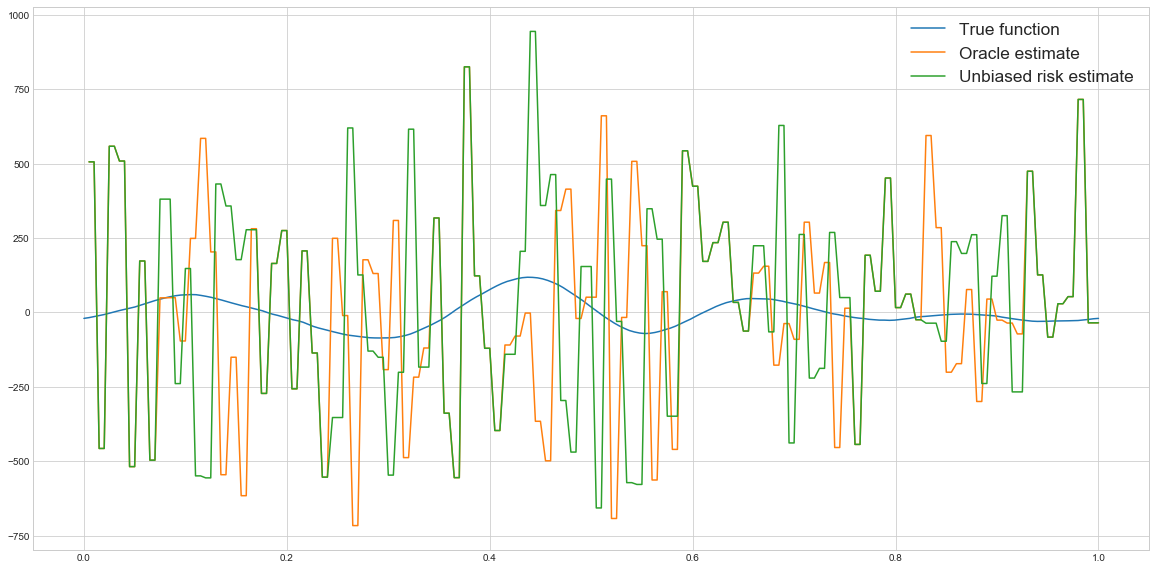

In [27]:
plt.figure(figsize=(20,10));
plt.plot(xx, f_prime_star(xx), label='True function');
plt.plot(X, est_oracle, label='Oracle estimate');
plt.plot(X, est_unb, label='Unbiased risk estimate');
plt.legend(fontsize='xx-large');

## Step 6.1. Understanding mistakes

In [28]:
m = 14
psi = get_psi(m)
s = np.linalg.pinv(psi @ psi.T) @ psi
w = get_w(m)
k = psi.T @ s
est_oracle = k @ Y_hom
m = 8
psi = get_psi(m)
s = np.linalg.pinv(psi @ psi.T) @ psi
w = get_w(m)
k = psi.T @ s
est_unb = k @ Y_hom

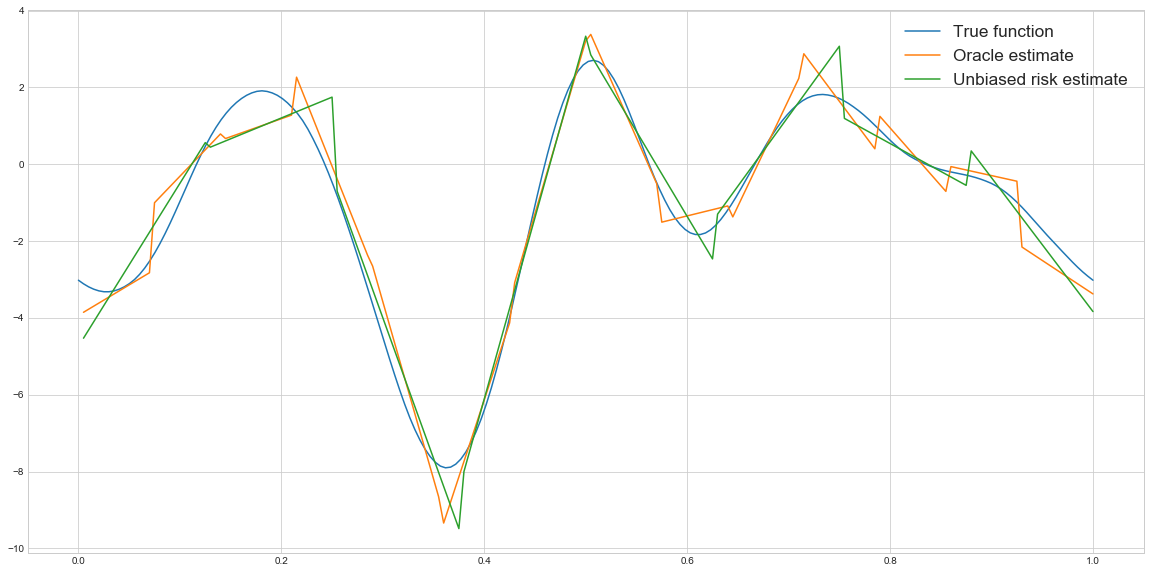

In [29]:
plt.figure(figsize=(20,10));
plt.plot(xx, f_star(xx), label='True function');
plt.plot(X, est_oracle, label='Oracle estimate');
plt.plot(X, est_unb, label='Unbiased risk estimate');
plt.legend(fontsize='xx-large');

In [30]:
def get_psi_new(m):
    psi = np.zeros((m+1, n))
    breaks = np.arange(m+1)/m
    psi[0] = np.ones(n)
    for k in range(m):
        idx = np.where(X > breaks[k])[0]
        psi[1+k, idx] = X[idx]-breaks[k]
    return psi

def get_w_new(m):
    w = np.zeros((n, m+1))
    breaks = np.arange(m+1)/m
    for k in range(m):
        idx = np.where(X > breaks[k])[0]
        w[idx, 1+k] = 1
    return w

def get_oracle_risks(y, Sigma):
    risks = np.zeros_like(M, dtype=np.float32)
    losses = np.zeros_like(M, dtype=np.float32)
    for i, m in enumerate(M):
        psi = get_psi_new(m)
        s = np.linalg.pinv(psi @ psi.T) @ psi
        w = get_w_new(m)
        k = w @ s
        loss = np.linalg.norm(k @ y - f_prime_star(X), ord=2) ** 2
        risk = np.linalg.norm(k @ f_star(X) - f_prime_star(X), ord=2) ** 2 + np.trace(k @ Sigma @ k.T)
        risks[i] = risk
        losses[i] = loss
    return risks, losses

def get_unb_risks(y, Sigma, m_largest=100):
    psi_largest = get_psi_new(m_largest)
    s_largest = np.linalg.pinv(psi_largest @ psi_largest.T) @ psi_largest
    w_largest = get_w_new(m_largest)
    k_largest = w_largest @ s_largest
    risks = np.zeros_like(M, dtype=np.float32)
    for i, m in enumerate(M):
        psi = get_psi(m)
        s = np.linalg.pinv(psi @ psi.T) @ psi
        w = get_w(m)
        k = w @ s
        k_diff = k_largest - k
        phi_largest = k_largest @ y
        phi = k @ y
        p = np.trace(k @ Sigma @ k.T)
        p_diff = np.trace(k_diff @ Sigma @ k_diff.T)
        risk = np.linalg.norm(phi_largest - phi, ord=2) ** 2 + p - p_diff
        risks[i] = risk
    return risks

def plot_risks(risks, losses, label):
    m = np.argmin(risks)+1
    plt.figure(figsize=(20,10));
    plt.plot(M, risks, label=label+' risk');
    if losses is not None:
        plt.plot(M, losses, label=label+' loss');
    if label == 'Oracle':
        plt.vlines(m, 0, np.max(risks), linestyles='dashed',
                   label='$m^\\ast = $%d' % m)
    elif label == 'Unbiased':
        plt.vlines(m, 0, np.max(risks), linestyles='dashed',
                   label='$\\hat{m} = $%d' % m)
    plt.legend(fontsize='xx-large');
    plt.xlabel('$m$', fontsize='xx-large');
    plt.show()
    
def plot_approx(m_oracle, m_unb, y):
    psi = get_psi_new(m_oracle)
    s = np.linalg.pinv(psi @ psi.T) @ psi
    w = get_w_new(m_oracle)
    k = w @ s
    est_oracle = k @ y
    psi = get_psi_new(m_unb)
    s = np.linalg.pinv(psi @ psi.T) @ psi
    w = get_w_new(m_unb)
    k = w @ s
    est_unb = k @ y
    plt.figure(figsize=(20,10));
    plt.plot(xx, f_prime_star(xx), label='True function');
    plt.plot(X, est_oracle, label='Oracle estimate');
    plt.plot(X, est_unb, label='Unbiased risk estimate');
    plt.legend(fontsize='xx-large');
    
def plot_func_approx(m_oracle, m_unb, y):
    psi = get_psi_new(m_oracle)
    s = np.linalg.pinv(psi @ psi.T) @ psi
    k = psi.T @ s
    est_oracle = k @ y
    psi = get_psi_new(m_unb)
    s = np.linalg.pinv(psi @ psi.T) @ psi
    k = psi.T @ s
    est_unb = k @ y
    plt.figure(figsize=(20,10));
    plt.plot(xx, f_star(xx), label='True function');
    plt.plot(X, est_oracle, label='Oracle estimate');
    plt.plot(X, est_unb, label='Unbiased risk estimate');
    plt.legend(fontsize='xx-large');

## Step 6.2. Oracle prediction and oracle risk
### Inhomogeneous noise

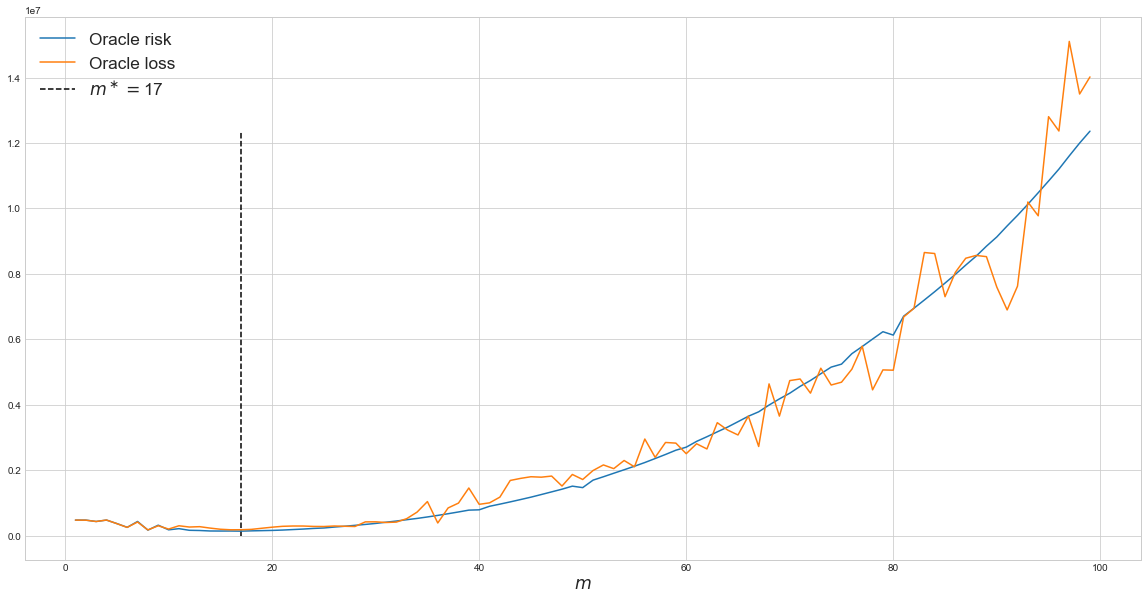

In [31]:
risks_inhom_2, losses_inhom_2 = get_oracle_risks(Y_inhom, np.diag(inhom_variances))
plot_risks(risks_inhom_2, losses_inhom_2, 'Oracle')

### Homogeneous noise

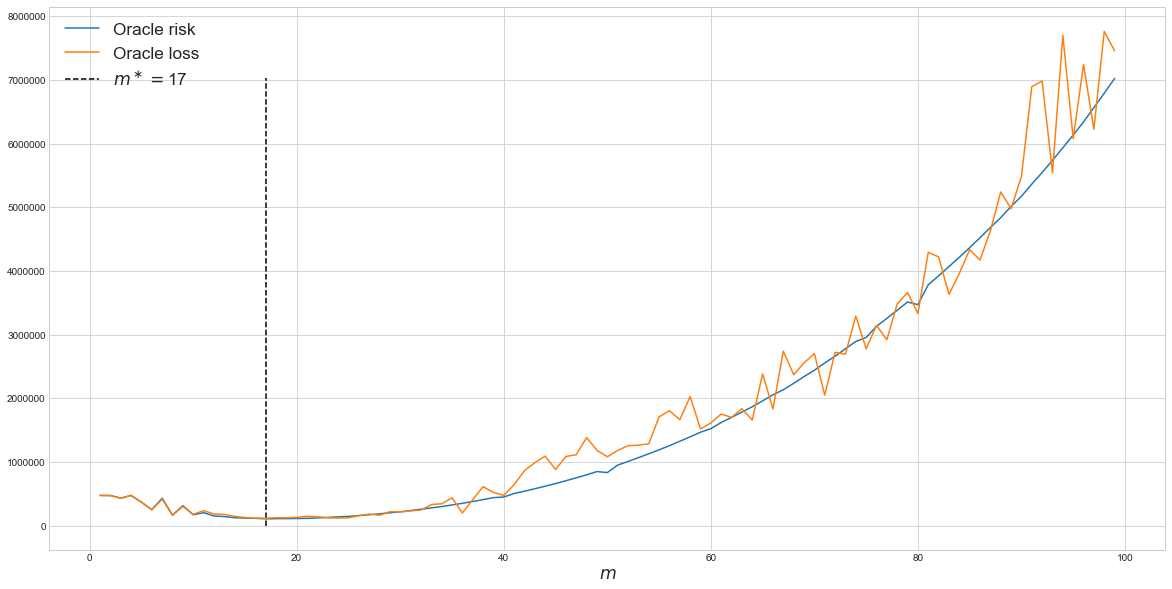

In [32]:
risks_hom_2, losses_hom_2 = get_oracle_risks(Y_hom, hom_variance*np.eye(n))
plot_risks(risks_hom_2, losses_hom_2, 'Oracle')

## Step 6.3. Unbiased risk estimate
### Inhomogeneous noise

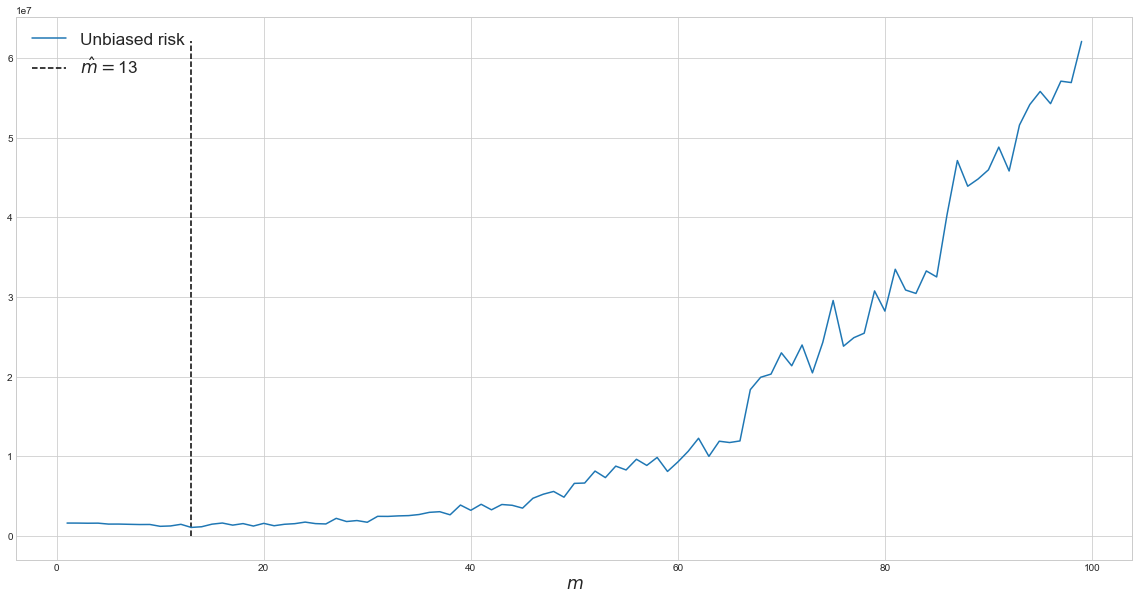

In [33]:
risks_inhom_unb_2 = get_unb_risks(Y_inhom, unsp_inhom_variance*np.eye(n))
plot_risks(risks_inhom_unb_2, None, 'Unbiased')

### Homogeneous noise

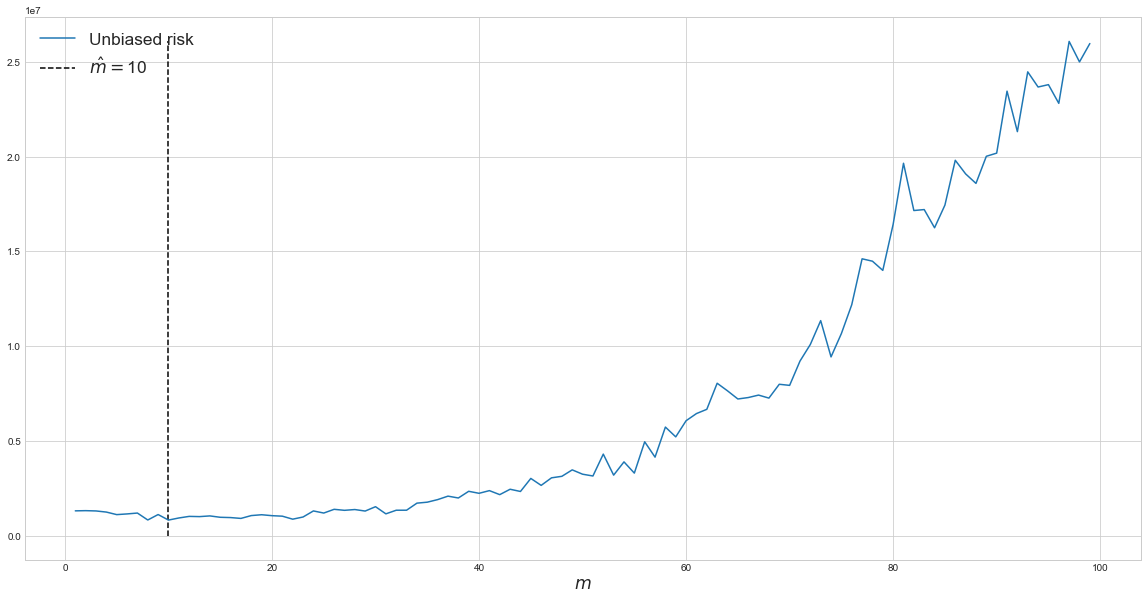

In [34]:
risks_hom_unb_2 = get_unb_risks(Y_hom, unsp_hom_variance*np.eye(n))
plot_risks(risks_hom_unb_2, None, 'Unbiased')

## Step 6.4. Visualization
### Inhomogeneous noise

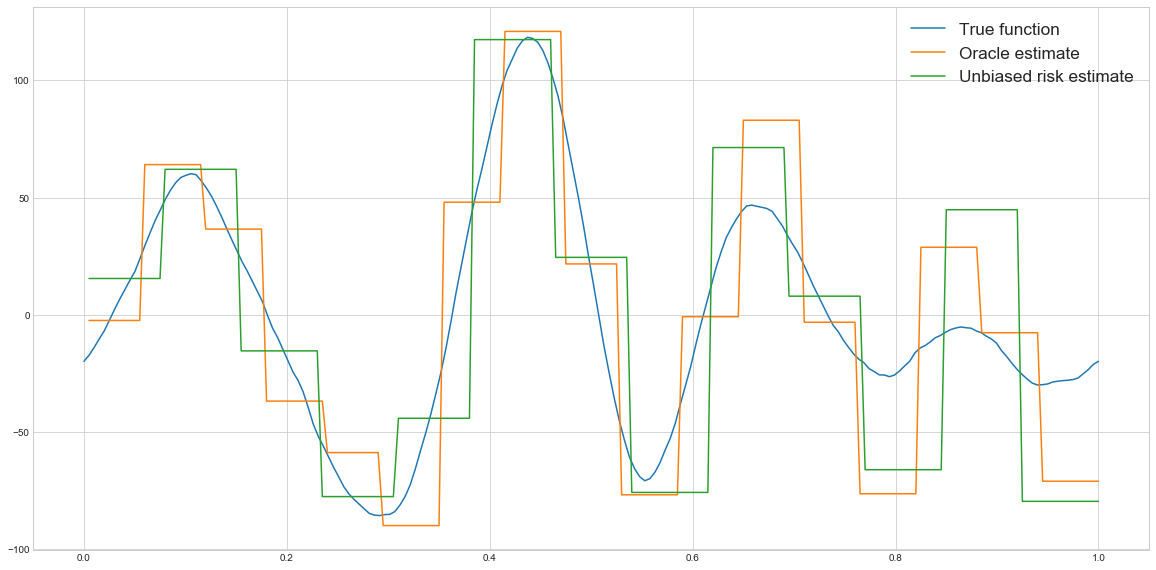

In [35]:
plot_approx(17, 13, Y_inhom)

### Homogeneous noise

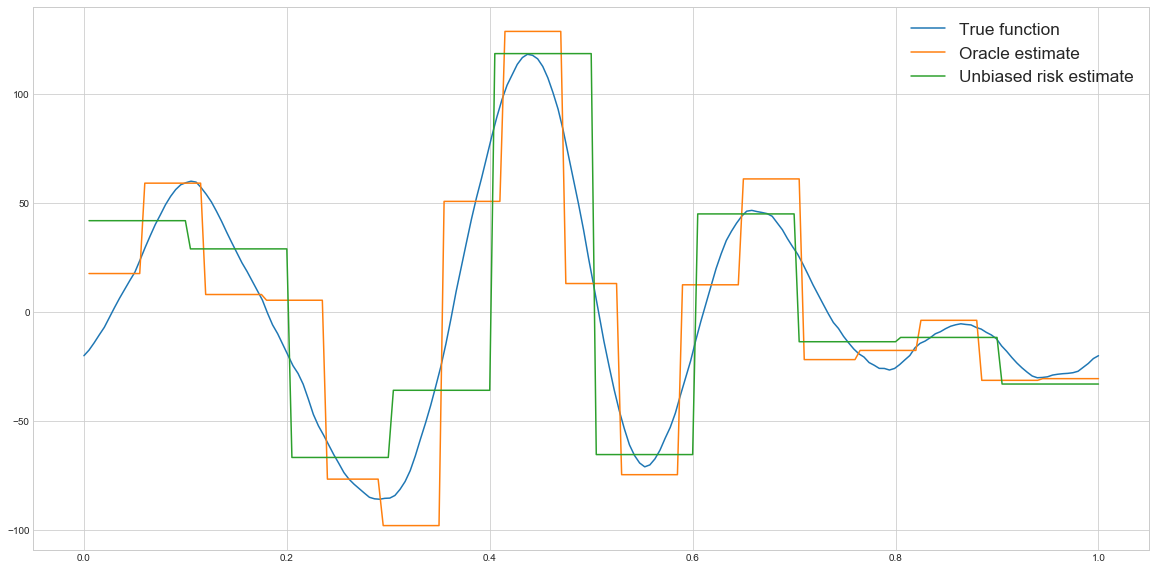

In [36]:
plot_approx(17, 10, Y_hom)

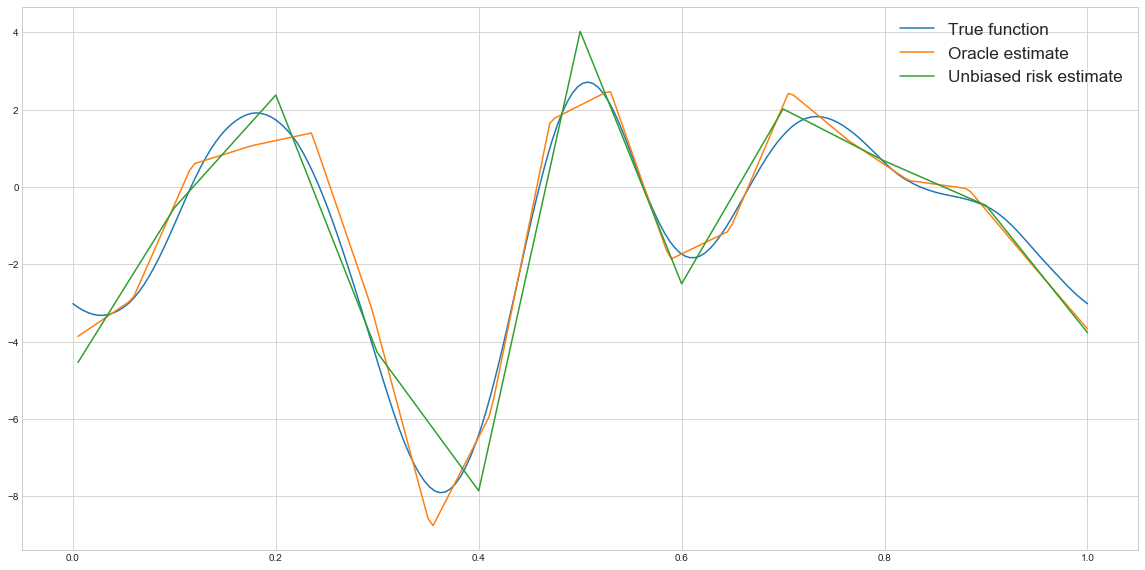

In [37]:
plot_func_approx(17, 10, Y_hom)